# Clustering

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special as sp
import pycodamath as coda
from pycodamath import plot
from pycodamath import extra
import scipy.optimize as optimization

#### 1. Data Loading

In [2]:
import pandas as pd
import re

# Load data
data = pd.read_csv('../data/2-meteorites.csv', sep=',')
data.rename(columns={'Unnamed: 0': 'Location'}, inplace=True)

# Strip leading and trailing spaces from all column names
data.columns = data.columns.str.strip()

# Extract the part inside parentheses into 'Type'
data['Type'] = data['Location'].str.extract(r'\((.*?)\)')

# Remove the parentheses and content from 'Location'
data['Location'] = data['Location'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()

# Reorder columns: Location, Type, then the rest
cols = ['Location', 'Type'] + [col for col in data.columns if col not in ['Location', 'Type']]
data = data[cols]

# Check result
print(data.head())
print(data.shape)


    Location Type   SiO2  Al2O3    FeO   MnO    MgO     Fe    Ni    Co     C
0    Allende   cc  34.23   3.27  27.15  0.18  24.62   0.17  0.36  0.01  0.29
1       Bali   cc  33.77   3.16  26.51  0.19  24.54   0.15  0.22  0.01  0.57
2  Efremovka   cc  34.31   3.37  17.20  0.19  24.71   5.51  1.37  0.06  0.76
3   Coolidge   cc  34.42   3.31   7.26  0.24  24.99   8.28  1.35  0.08  0.19
4    Ankober   hc  35.35   2.32  13.05  0.32  22.86  13.96  1.71  0.10  0.10
(12, 11)


#### 2. PCA

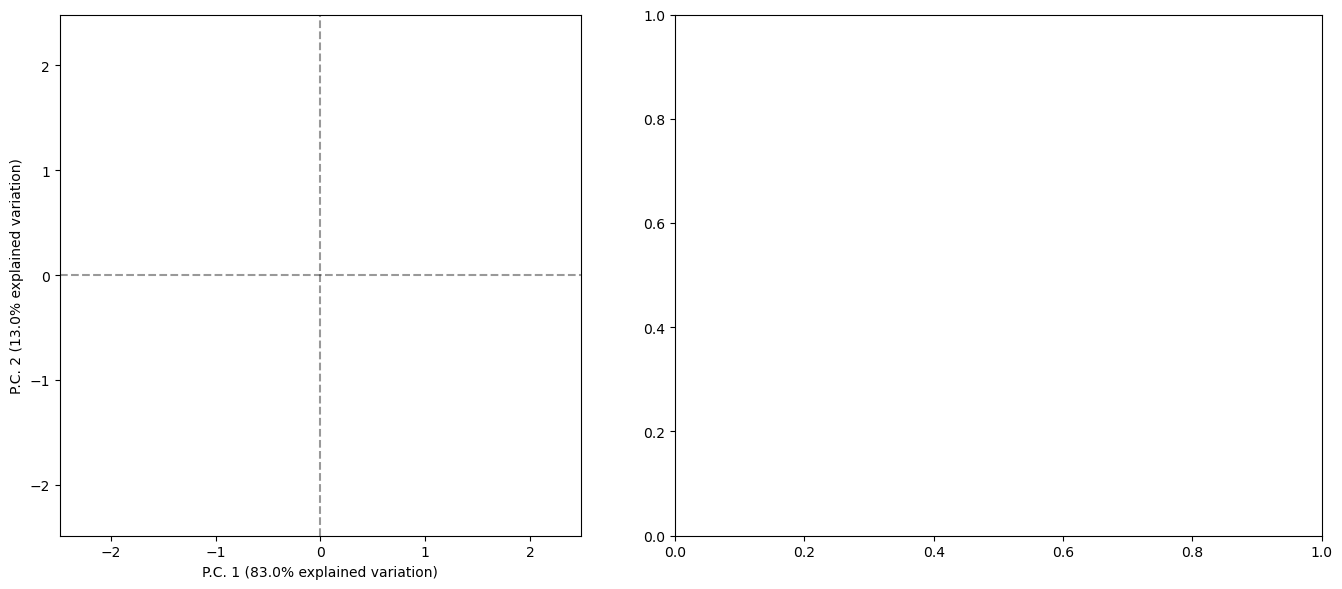

In [ ]:
import matplotlib.pyplot as plt

# Define colors for each Type class
unique_types = data['Type'].unique()
color_map = {type_name: color for type_name, color in zip(unique_types, plt.cm.tab10.colors)}

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Create the biplot object, telling it to use ax1
mypca = coda.pca.Biplot(data.iloc[:, 2:], axis=ax1, default=False)
